## Required packages
numpy, matplotlib, statsmodels, numba, seaborn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from signals import *
from frequencyestimator import *
from scipy.optimize import curve_fit
import scipy.stats as st 
from pathlib import Path
import statsmodels.api as sm
from util import *
from csae import *
from tqdm import tqdm


from chebAE import chebae

sns.set_style("whitegrid")

sns.despine(left=True, bottom=True)
sns.set_context("poster", font_scale = .45, rc={"grid.linewidth": 0.8})

<Figure size 640x480 with 0 Axes>

In [2]:
# Helper function to simulate the chebAE approach from Quantum 7, 937 (2023) and store output values needed for plots

def simulate_chebAE(avals, epsilons, delta, num_mc):   
    np.random.seed(7) # Seed for reproducible results
    errors = np.zeros((len(epsilons), num_mc), dtype = float)
    queries = np.zeros((len(epsilons), num_mc), dtype = float)
    time_complexity = np.zeros((len(epsilons), num_mc), dtype = float)

    for i, eps in enumerate(epsilons):
        q,d,t=0,0,0
        for j in range(num_mc):
            res = chebae(avals[j], eps, delta)
            q += res['queries']
            t += res['time_complexity']
            
            time_complexity[i,j] = res['time_complexity']
            queries[i,j] = res['queries']
            errors[i,j] = np.abs(res['a_hat']-avals[j])

    return errors, queries, time_complexity

In [3]:
def one_parameter_fits(epsilons, queries):   

    epsilons = np.array(epsilons)
    queries = np.array(queries)

    mod_wls = sm.WLS(epsilons, sm.add_constant(1.0/queries), weights=1.0 / (epsilons ** 2))
    res_wls = mod_wls.fit()
    
    return res_wls.params[1], res_wls.bse[1]

## Data in Table I

In [4]:
# Load precomputed data from run_ae_sims.py and compute fit line to estimate constant factor.
# Average fit line over each amplitude to compute average constant factor independent of a

C95 = 4.0

# Use a sampling parameter C=1.3 for confidence intervals <= 95%
dir='sims/'
with open(dir+f'csae_C{C95:0.3f}_mc0500.pkl', 'rb') as handle:
    errors, thetas, errors_exact_signs, thetas_exact_signs, num_queries, max_single_query, arrays, num_lengths, num_mc, avals = pickle.load(handle)

C99 = 8.0

# Use a sampling parameter C=1.8 for confidence intervals == 99%
dir='sims/'
with open(dir+f'csae_C{C99:0.3f}_mc0500.pkl', 'rb') as handle:
    errors99, thetas99, errors_exact_signs99, thetas_exact_signs99, num_queries99, max_single_query99, arrays99, num_lengths99, num_mc99, avals99 = pickle.load(handle)

# First 2 are for very high error rates and not useful
errors = errors[2:]
thetas = thetas[2:]
num_queries = num_queries[2:]
max_single_query = max_single_query[2:]
num_lengths = num_lengths-2

# First 2 are for very high error rates and not useful
errors99 = errors99[2:]
thetas99 = thetas99[2:]
num_queries99 = num_queries99[2:]
max_single_query99 = max_single_query99[2:]
num_lengths99 = num_lengths99-2

ninetyninepercentile = np.percentile(errors99, 99, axis=1)
ninetyfivepercentile = np.percentile(errors, 95, axis=1)
sixtyeightpercentile = np.percentile(errors, 68, axis=1)
median = np.percentile(errors, 50, axis=1)

C_csae99      = one_parameter_fits(ninetyninepercentile, num_queries99)
C_csae_time99 = one_parameter_fits(ninetyninepercentile, max_single_query99)
C_csae_ave99          = C_csae99[0]
C_csae_ave_dev99      = C_csae99[1]
C_csae_ave_time99     = C_csae_time99[0]
C_csae_ave_time_dev99 = C_csae_time99[1]

C_csae95      = one_parameter_fits(ninetyfivepercentile, num_queries)
C_csae_time95 = one_parameter_fits(ninetyfivepercentile, max_single_query)
C_csae_ave95          = C_csae95[0]
C_csae_ave_dev95      = C_csae95[1]
C_csae_ave_time95     = C_csae_time95[0]
C_csae_ave_time_dev95 = C_csae_time95[1]

C_csae68      = one_parameter_fits(sixtyeightpercentile, num_queries)
C_csae_time68 = one_parameter_fits(sixtyeightpercentile, max_single_query)
C_csae_ave68          = C_csae68[0]
C_csae_ave_dev68      = C_csae68[1]
C_csae_ave_time68     = C_csae_time68[0]
C_csae_ave_time_dev68 = C_csae_time68[1]

C_csae50      = one_parameter_fits(median, num_queries)
C_csae_time50 = one_parameter_fits(median, max_single_query)
C_csae_ave50          = C_csae50[0]
C_csae_ave_dev50      = C_csae50[1]
C_csae_ave_time50     = C_csae_time50[0]
C_csae_ave_time_dev50 = C_csae_time50[1]

In [5]:
# Simulates the approach from Quantum 7, 937 (2023) for the output epsilons obtained from the csAE approach 
# for 99%, 95%, 68%, and 50%. Saves the files for future use to save time when plotting.

# Same number of samples as for csAE
num_mc_chebae=500

# Load or simulate chebAE for confidence levels 99%, 95%, 68%, and 50% for each amplitude

print(f'C99={C99:0.3f}')

chebae_file = dir+f'chebae_C{C99:0.3f}_mc{num_mc_chebae:04d}_99.pkl'
if Path(chebae_file).is_file():
    # file exists
    print('99% ChebAE Load')
    with open(chebae_file, 'rb') as handle:
        errors_chebae99, queries_chebae99, time_complexity_chebae99 = pickle.load(handle)
else:
    print('99% ChebAE Sim')
    errors_chebae99, queries_chebae99, time_complexity_chebae99 = \
        simulate_chebAE(avals=avals99, epsilons=ninetyninepercentile, delta=0.01, num_mc=num_mc_chebae)
    with open(chebae_file, 'wb') as handle:
        pickle.dump((errors_chebae99, queries_chebae99, time_complexity_chebae99), 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)  

# compute the average, max, and min number of queries both for total complexity and time complexity.
# Time complexity is the maximum coherent depth and indicates the parallelizability of the algorithm
ave_num_queries_chebae99     = np.mean(queries_chebae99, axis=1)
max_num_queries_chebae99     = np.max(queries_chebae99, axis=1)
min_num_queries_chebae99     = np.min(queries_chebae99, axis=1)
ave_time_complexity_chebae99 = np.mean(time_complexity_chebae99, axis=1)
max_time_complexity_chebae99 = np.max(time_complexity_chebae99, axis=1)
min_time_complexity_chebae99 = np.min(time_complexity_chebae99, axis=1)
ninetyninepercentile_chebae  = np.percentile(errors_chebae99, 99, axis=1)

# Fit the curves to get the constant factor
C_cheb99          = one_parameter_fits(ninetyninepercentile_chebae, ave_num_queries_chebae99)
C_cheb_max99      = one_parameter_fits(ninetyninepercentile_chebae, max_num_queries_chebae99)
C_cheb_time99     = one_parameter_fits(ninetyninepercentile_chebae, ave_time_complexity_chebae99)
C_cheb_time_max99 = one_parameter_fits(ninetyninepercentile_chebae, max_time_complexity_chebae99)

print(f'C95={C95:0.3f}')
# Do the same for the rest of the percentiles. Probably should be done in a function, but this is the lazy way.
chebae_file = dir+f'chebae_C{C95:0.3f}_mc{num_mc_chebae:04d}_95.pkl'
if Path(chebae_file).is_file():
    # file exists
    print('95% ChebAE Load')
    with open(chebae_file, 'rb') as handle:
        errors_chebae95, queries_chebae95, time_complexity_chebae95 = pickle.load(handle)
else:
    print('95% ChebAE Sim')
    errors_chebae95, queries_chebae95, time_complexity_chebae95 = \
        simulate_chebAE(avals=avals, epsilons=ninetyfivepercentile, delta=0.05, num_mc=num_mc_chebae)
    with open(chebae_file, 'wb') as handle:
        pickle.dump((errors_chebae95, queries_chebae95, time_complexity_chebae95), 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)  

ave_num_queries_chebae95     = np.mean(queries_chebae95, axis=1)
max_num_queries_chebae95     = np.max(queries_chebae95, axis=1)
min_num_queries_chebae95     = np.min(queries_chebae95, axis=1)
ave_time_complexity_chebae95 = np.mean(time_complexity_chebae95, axis=1)
max_time_complexity_chebae95 = np.max(time_complexity_chebae95, axis=1)
min_time_complexity_chebae95 = np.min(time_complexity_chebae95, axis=1)
ninetyfivepercentile_chebae  = np.percentile(errors_chebae95, 95, axis=1)

C_cheb95          = one_parameter_fits(ninetyfivepercentile_chebae, ave_num_queries_chebae95)
C_cheb_max95      = one_parameter_fits(ninetyfivepercentile_chebae, max_num_queries_chebae95)
C_cheb_time95     = one_parameter_fits(ninetyfivepercentile_chebae, ave_time_complexity_chebae95)
C_cheb_time_max95 = one_parameter_fits(ninetyfivepercentile_chebae, max_time_complexity_chebae95)

chebae_file = dir+f'chebae_C{C95:0.3f}_mc{num_mc_chebae:04d}_68.pkl'
if Path(chebae_file).is_file():
    # file exists
    print('68% ChebAE Load')
    with open(chebae_file, 'rb') as handle:
        errors_chebae68, queries_chebae68, time_complexity_chebae68 = pickle.load(handle)
else:
    print('68% ChebAE Sim')
    errors_chebae68, queries_chebae68, time_complexity_chebae68 = \
        simulate_chebAE(avals=avals, epsilons=sixtyeightpercentile, delta=0.32, num_mc=num_mc_chebae)
    with open(chebae_file, 'wb') as handle:
        pickle.dump((errors_chebae68, queries_chebae68, time_complexity_chebae68), 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)  

ave_num_queries_chebae68     = np.mean(queries_chebae68, axis=1)
max_num_queries_chebae68     = np.max(queries_chebae68, axis=1)
min_num_queries_chebae68     = np.min(queries_chebae68, axis=1)
ave_time_complexity_chebae68 = np.mean(time_complexity_chebae68, axis=1)
max_time_complexity_chebae68 = np.max(time_complexity_chebae68, axis=1)
min_time_complexity_chebae68 = np.min(time_complexity_chebae68, axis=1)
sixtyeightpercentile_chebae  = np.percentile(errors_chebae68, 68, axis=1)

C_cheb68          = one_parameter_fits(sixtyeightpercentile_chebae, ave_num_queries_chebae68)
C_cheb_max68      = one_parameter_fits(sixtyeightpercentile_chebae, max_num_queries_chebae68)
C_cheb_time68     = one_parameter_fits(sixtyeightpercentile_chebae, ave_time_complexity_chebae68)
C_cheb_time_max68 = one_parameter_fits(sixtyeightpercentile_chebae, max_time_complexity_chebae68)

chebae_file = dir+f'chebae_C{C95:0.3f}_mc{num_mc_chebae:04d}_50.pkl'
if Path(chebae_file).is_file():
    # file exists
    print('50% ChebAE Load')
    with open(chebae_file, 'rb') as handle:
        errors_chebae50, queries_chebae50, time_complexity_chebae50 = pickle.load(handle)
else:    
    print('50% ChebAE Sim')
    errors_chebae50, queries_chebae50, time_complexity_chebae50 = \
        simulate_chebAE(avals=avals, epsilons=median, delta=0.5, num_mc=num_mc_chebae)
    with open(chebae_file, 'wb') as handle:
        pickle.dump((errors_chebae50, queries_chebae50, time_complexity_chebae50), 
                    handle, protocol=pickle.HIGHEST_PROTOCOL) 

ave_num_queries_chebae50     = np.mean(queries_chebae50, axis=1)
max_num_queries_chebae50     = np.max(queries_chebae50, axis=1)
min_num_queries_chebae50     = np.min(queries_chebae50, axis=1)
ave_time_complexity_chebae50 = np.mean(time_complexity_chebae50, axis=1)
max_time_complexity_chebae50 = np.max(time_complexity_chebae50, axis=1)
min_time_complexity_chebae50 = np.min(time_complexity_chebae50, axis=1)
median_chebae                = np.percentile(errors_chebae50, 50, axis=1)

C_cheb50          = one_parameter_fits(median_chebae, ave_num_queries_chebae50)
C_cheb_max50      = one_parameter_fits(median_chebae, max_num_queries_chebae50)
C_cheb_time50     = one_parameter_fits(median_chebae, ave_time_complexity_chebae50)
C_cheb_time_max50 = one_parameter_fits(median_chebae, max_time_complexity_chebae50)


# Report out the various slopes and standard deviations
C_cheb_ave99          = C_cheb99[0]
C_cheb_ave_time99     = C_cheb_time99[0]
C_cheb_ave_dev99      = C_cheb99[1]
C_cheb_ave_time_dev99 = C_cheb_time99[1]

C_cheb_ave_max99          = C_cheb_max99[0]
C_cheb_ave_time_max99     = C_cheb_time_max99[0]
C_cheb_ave_dev_max99      = C_cheb_max99[1]
C_cheb_ave_time_dev_max99 = C_cheb_time_max99[1]

C_cheb_ave95          = C_cheb95[0]
C_cheb_ave_time95     = C_cheb_time95[0]
C_cheb_ave_dev95      = C_cheb95[1]
C_cheb_ave_time_dev95 = C_cheb_time95[1]

C_cheb_ave_max95          = C_cheb_max95[0]
C_cheb_ave_time_max95     = C_cheb_time_max95[0]
C_cheb_ave_dev_max95      = C_cheb_max95[1]
C_cheb_ave_time_dev_max95 = C_cheb_time_max95[1]

C_cheb_ave68          = C_cheb68[0]
C_cheb_ave_time68     = C_cheb_time68[0]
C_cheb_ave_dev68      = C_cheb68[1]
C_cheb_ave_time_dev68 = C_cheb_time68[1]

C_cheb_ave_max68          = C_cheb_max68[0]
C_cheb_ave_time_max68     = C_cheb_time_max68[0]
C_cheb_ave_dev_max68      = C_cheb_max68[1]
C_cheb_ave_time_dev_max68 = C_cheb_time_max68[1]

C_cheb_ave50          = C_cheb50[0]
C_cheb_ave_time50     = C_cheb_time50[0]
C_cheb_ave_dev50      = C_cheb50[1]
C_cheb_ave_time_dev50 = C_cheb_time50[1]

C_cheb_ave_max50          = C_cheb_max50[0]
C_cheb_ave_time_max50     = C_cheb_time_max50[0]
C_cheb_ave_dev_max50      = C_cheb_max50[1]
C_cheb_ave_time_dev_max50 = C_cheb_time_max50[1]

C99=8.000
99% ChebAE Load
C95=4.000
95% ChebAE Load
68% ChebAE Load
50% ChebAE Load


# Table 1 parameters

In [6]:
# Gets the fit parameters for csA and chebAE for both total query complexity as well as parallel query complexity (denoted as time). 
# This is the query complexity assuming access to as many quantum computers as required to fully parallelize the problem.

# Computes fits for both average case and worst case for chebAE. For csAE there is no variation in schedule, so 
# average case and worst case are the same. 

print('99% Fits Average Case')
print(f'  99% CS Sequential Constant Factor: {C_csae_ave99:0.3f} +- {C_csae_ave_dev99:0.3f}')
print(f'  99% CS Parallel Constant Factor: {C_csae_ave_time99:0.3f}  +- {C_csae_ave_time_dev99:0.3f}')
print(f'  99% Cheb Sequential Constant Factor: {C_cheb_ave99:0.3f} +- {C_cheb_ave_dev99:0.3f}')
print(f'  99% Cheb Parallel Constant Factor: {C_cheb_ave_time99:0.3f} +- {C_cheb_ave_time_dev99:0.3f}')
print(f'  99% Sequential Ratio: {C_cheb_ave99/C_csae_ave99:0.3f}')
print(f'  99% Parallel Ratio: {C_cheb_ave_time99/C_csae_ave_time99:0.3f}')

print('\n\n95% Fits Average Case')

print(f'  95% CS Sequential Constant Factor: {C_csae_ave95:0.3f} +- {C_csae_ave_dev95:0.3f}')
print(f'  95% CS Parallel Constant Factor: {C_csae_ave_time95:0.3f}  +- {C_csae_ave_time_dev95:0.3f}')
print(f'  95% Cheb Sequential Constant Factor: {C_cheb_ave95:0.3f} +- {C_cheb_ave_dev95:0.3f}')
print(f'  95% Cheb Parallel Constant Factor: {C_cheb_ave_time95:0.3f} +- {C_cheb_ave_time_dev95:0.3f}')
print(f'  95% Sequential Ratio: {C_cheb_ave95/C_csae_ave95:0.3f}')
print(f'  95% Parallel Ratio: {C_cheb_ave_time95/C_csae_ave_time95:0.3f}')

print('\n\n68% Fits Average Case')

print(f'  68% CS Sequential Constant Factor: {C_csae_ave68:0.3f} +- {C_csae_ave_dev68:0.3f}')
print(f'  68% CS Parallel Constant Factor: {C_csae_ave_time68:0.3f}  +- {C_csae_ave_time_dev68:0.3f}')
print(f'  68% Cheb Sequential Constant Factor: {C_cheb_ave68:0.3f} +- {C_cheb_ave_dev68:0.3f}')
print(f'  68% Cheb Parallel Constant Factor: {C_cheb_ave_time68:0.3f} +- {C_cheb_ave_time_dev68:0.3f}')
print(f'  68% Sequential Ratio: {C_cheb_ave68/C_csae_ave68:0.3f}')
print(f'  68% Parallel Ratio: {C_cheb_ave_time68/C_csae_ave_time68:0.3f}')

print('\n\nMedian Fits Average Case')

print(f'  50% CS Sequential Constant Factor: {C_csae_ave50:0.3f} +- {C_csae_ave_dev50:0.3f}')
print(f'  50% CS Parallel Constant Factor: {C_csae_ave_time50:0.3f}  +- {C_csae_ave_time_dev50:0.3f}')
print(f'  50% Cheb Sequential Constant Factor: {C_cheb_ave50:0.3f} +- {C_cheb_ave_dev50:0.3f}')
print(f'  50% Cheb Parallel Constant Factor: {C_cheb_ave_time50:0.3f} +- {C_cheb_ave_time_dev50:0.3f}')
print(f'  50% Sequential Ratio: {C_cheb_ave50/C_csae_ave50:0.3f}')
print(f'  50% Parallel Ratio: {C_cheb_ave_time50/C_csae_ave_time50:0.3f}')



print('\n\n99% Fits Worst Case')
print(f'  99% CS Sequential Constant Factor: {C_csae_ave99:0.3f} +- {C_csae_ave_dev99:0.3f}')
print(f'  99% CS Parallel Constant Factor: {C_csae_ave_time99:0.3f} +- {C_csae_ave_time_dev99:0.3f}')
print(f'  99% Cheb Sequential Constant Factor: {C_cheb_ave_max99:0.3f} +- {C_cheb_ave_dev_max99:0.3f}')
print(f'  99% Cheb Parallel Constant Factor: {C_cheb_ave_time_max99:0.3f} +- {C_cheb_ave_time_dev_max99:0.3f}')
print(f'  99% Sequential Ratio Max: {C_cheb_ave_max99/C_csae_ave99:0.3f}')
print(f'  99% Parallel Ratio Max: {C_cheb_ave_time_max99/C_csae_ave_time99:0.3f}')

print('\n\n95% Fits Worst Case')

print(f'  95% CS Sequential Constant Factor: {C_csae_ave95:0.3f} +- {C_csae_ave_dev95:0.3f}')
print(f'  95% CS Parallel Constant Factor: {C_csae_ave_time95:0.3f} +- {C_csae_ave_time_dev95:0.3f}')
print(f'  95% Cheb Sequential Constant Factor: {C_cheb_ave_max95:0.3f} +- {C_cheb_ave_dev_max95:0.3f}')
print(f'  95% Cheb Parallel Constant Factor: {C_cheb_ave_time_max95:0.3f} +- {C_cheb_ave_time_dev_max95:0.3f}')
print(f'  95% Sequential Ratio Max: {C_cheb_ave_max95/C_csae_ave95:0.3f}')
print(f'  95% Parallel Ratio Max: {C_cheb_ave_time_max95/C_csae_ave_time95:0.3f}')

print('\n\n68% Fits Worst Case')

print(f'  68% CS Sequential Constant Factor: {C_csae_ave68:0.3f} +- {C_csae_ave_dev68:0.3f}')
print(f'  68% CS Parallel Constant Factor: {C_csae_ave_time68:0.3f} +- {C_csae_ave_time_dev68:0.3f}')
print(f'  68% Cheb Sequential Constant Factor: {C_cheb_ave_max68:0.3f} +- {C_cheb_ave_dev_max68:0.3f}')
print(f'  68% Cheb Parallel Constant Factor: {C_cheb_ave_time_max68:0.3f} +- {C_cheb_ave_time_dev_max68:0.3f}')
print(f'  68% Sequential Ratio Max: {C_cheb_ave_max68/C_csae_ave68:0.3f}')
print(f'  68% Parallel Ratio Max: {C_cheb_ave_time_max68/C_csae_ave_time68:0.3f}')

print('\n\nMedian Fits Worst Case')

print(f'  50% CS Sequential Constant Factor: {C_csae_ave50:0.3f} +- {C_csae_ave_dev50:0.3f}')
print(f'  50% CS Parallel Constant Factor: {C_csae_ave_time50:0.3f} +- {C_csae_ave_time_dev50:0.3f}')
print(f'  50% Cheb Sequential Constant Factor: {C_cheb_ave_max50:0.3f} +- {C_cheb_ave_dev_max50:0.3f}')
print(f'  50% Cheb Parallel Constant Factor: {C_cheb_ave_time_max50:0.3f} +- {C_cheb_ave_time_dev_max50:0.3f}')
print(f'  50% Sequential Ratio Max: {C_cheb_ave_max50/C_csae_ave50:0.3f}')
print(f'  50% Parallel Ratio Max: {C_cheb_ave_time_max50/C_csae_ave_time50:0.3f}')

99% Fits Average Case
  99% CS Sequential Constant Factor: 8.990 +- 0.947
  99% CS Parallel Constant Factor: 0.272  +- 0.031
  99% Cheb Sequential Constant Factor: 4.087 +- 0.234
  99% Cheb Parallel Constant Factor: 3.908 +- 0.157
  99% Sequential Ratio: 0.455
  99% Parallel Ratio: 14.363


95% Fits Average Case
  95% CS Sequential Constant Factor: 4.347 +- 0.136
  95% CS Parallel Constant Factor: 0.264  +- 0.011
  95% Cheb Sequential Constant Factor: 3.065 +- 0.108
  95% Cheb Parallel Constant Factor: 2.950 +- 0.060
  95% Sequential Ratio: 0.705
  95% Parallel Ratio: 11.178


68% Fits Average Case
  68% CS Sequential Constant Factor: 1.674 +- 0.045
  68% CS Parallel Constant Factor: 0.102  +- 0.003
  68% Cheb Sequential Constant Factor: 1.295 +- 0.010
  68% Cheb Parallel Constant Factor: 1.191 +- 0.015
  68% Sequential Ratio: 0.774
  68% Parallel Ratio: 11.696


Median Fits Average Case
  50% CS Sequential Constant Factor: 1.103 +- 0.026
  50% CS Parallel Constant Factor: 0.067  +- 0.

## Fig. 3 95%

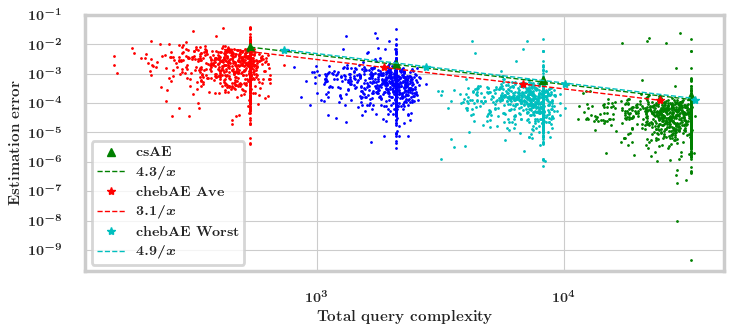

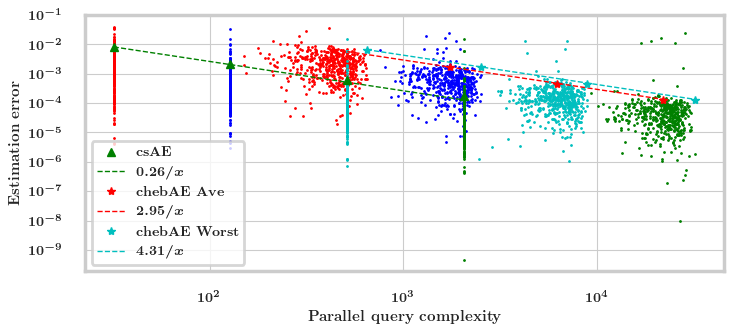

In [7]:
ms=2
lw=1
sns.set_style("whitegrid")

#QUERY COMPLEXITY
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["font.size"] = 12
plt.rcParams["text.latex.preamble"] = r'\boldmath'
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"]})

colors = ['r.', 'b.', 'c.', 'g.', 'k.']
for k in range(num_lengths):
    plt.plot([num_queries[k]]*num_mc, errors[k], colors[k % len(colors)], ms=ms)
    plt.plot(queries_chebae95[k], errors_chebae95[k], colors[k % len(colors)], ms=ms)

plt.plot(num_queries, ninetyfivepercentile, '^g', label=r'\textbf{csAE}', ms=6)
plt.plot(num_queries, C_csae95[0]/(num_queries), '--g', label=rf'${C_csae95[0]:.1f}/x$', linewidth=1)
plt.plot(ave_num_queries_chebae95, ninetyfivepercentile_chebae, '*r', label=r'\textbf{chebAE Ave}', ms=6)
plt.plot(ave_num_queries_chebae95, C_cheb95[0]/(ave_num_queries_chebae95), '--r', label=rf'${C_cheb95[0]:.1f}/x$', linewidth=1)
plt.plot(max_num_queries_chebae95, ninetyfivepercentile_chebae, '*c', label=r'\textbf{chebAE Worst}', ms=6)
plt.plot(max_num_queries_chebae95, C_cheb_max95[0]/(max_num_queries_chebae95), '--c', label=rf'${C_cheb_max95[0]:.1f}/x$', linewidth=1)

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'\textbf{Total query complexity}')
plt.ylabel(r'\textbf{Estimation error}')
plt.legend()
plt.tight_layout()
plt.savefig(dir+f'scaling_C{C95:0.3f}_sequential_query.pdf')

# TIME COMPLEXITY
plt.figure()

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["font.size"] = 12

colors = ['r.', 'b.', 'c.', 'g.', 'k.']
for k in range(num_lengths):
    plt.plot([max_single_query[k]]*num_mc, errors[k], colors[k % len(colors)], ms=ms)
    plt.plot(time_complexity_chebae95[k], errors_chebae95[k], colors[k % len(colors)], ms=ms)

   
# plt.plot(max_single_query, 0.1/(max_single_query), 'r', linewidth=1)
plt.plot(max_single_query, ninetyfivepercentile, '^g', label=r'\textbf{csAE}', ms=6)
plt.plot(max_single_query, C_csae_time95[0]/(max_single_query), '--g', label=rf'${C_csae_time95[0]:.2f}/x$', linewidth=1)
plt.plot(ave_time_complexity_chebae95, ninetyfivepercentile_chebae, '*r', label=r'\textbf{chebAE Ave}', ms=6)
plt.plot(ave_time_complexity_chebae95, C_cheb_time95[0]/(ave_time_complexity_chebae95), '--r', label=rf'${C_cheb_time95[0]:.2f}/x$', linewidth=1)
plt.plot(max_time_complexity_chebae95, ninetyfivepercentile_chebae, '*c', label=r'\textbf{chebAE Worst}', ms=6)
plt.plot(max_time_complexity_chebae95, C_cheb_time_max95[0]/(max_time_complexity_chebae95), '--c', label=rf'${C_cheb_time_max95[0]:.2f}/x$', linewidth=1)

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'\textbf{Parallel query complexity}')
plt.ylabel(r'\textbf{Estimation error}')
plt.legend()
plt.tight_layout()
plt.savefig(dir+f'scaling_C{C95:0.3f}_parallel_query.pdf')

## Fig 3 99% (Not shown in paper)

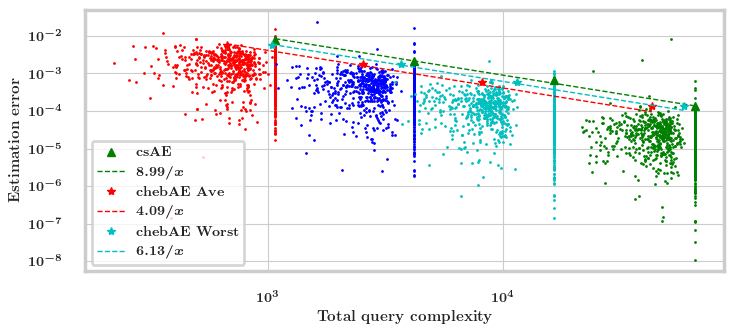

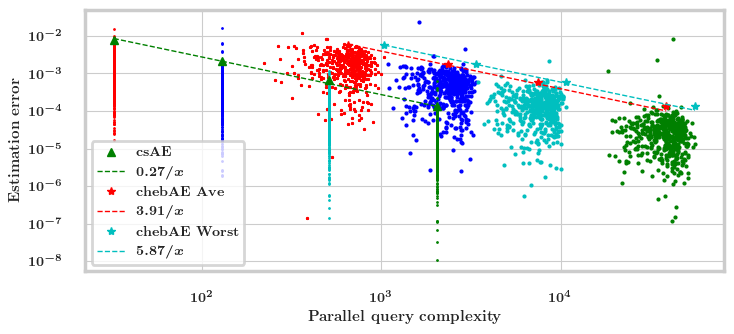

In [8]:
ms=2
lw=1
sns.set_style("whitegrid")

a=0.5

#QUERY COMPLEXITY
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["font.size"] = 12
plt.rcParams["text.latex.preamble"] = r'\boldmath'
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"]})

colors = ['r.', 'b.', 'c.', 'g.', 'k.']
for k in range(num_lengths):
    plt.plot([num_queries99[k]]*num_mc, errors99[k], colors[k % len(colors)], ms=ms)
    plt.plot(queries_chebae99[k], errors_chebae99[k], colors[k % len(colors)], ms=ms)


plt.plot(num_queries99, ninetyninepercentile, '^g', label=r'\textbf{csAE}', ms=6)
plt.plot(num_queries99, C_csae99[0]/(num_queries99), '--g', label=rf'${C_csae99[0]:.2f}/x$', linewidth=1)
plt.plot(ave_num_queries_chebae99, ninetyninepercentile_chebae, '*r', label=r'\textbf{chebAE Ave}', ms=6)
plt.plot(ave_num_queries_chebae99, C_cheb99[0]/(ave_num_queries_chebae99), '--r', label=rf'${C_cheb99[0]:.2f}/x$', linewidth=1)
plt.plot(max_num_queries_chebae99, ninetyninepercentile_chebae, '*c', label=r'\textbf{chebAE Worst}', ms=6)
plt.plot(max_num_queries_chebae99, C_cheb_max99[0]/(max_num_queries_chebae99), '--c', label=rf'${C_cheb_max99[0]:.2f}/x$', linewidth=1)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'\textbf{Total query complexity}')
plt.ylabel(r'\textbf{Estimation error}')
plt.legend()
plt.tight_layout()

# TIME COMPLEXITY
plt.figure()

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["font.size"] = 12

colors = ['r.', 'b.', 'c.', 'g.', 'k.']
colors_cheb = ['r*', 'bo', 'co', 'go', 'ko']
for k in range(num_lengths):
    plt.plot([max_single_query99[k]]*num_mc, errors99[k], colors[k % len(colors)], ms=ms)
    plt.plot(time_complexity_chebae99[k], errors_chebae99[k], colors_cheb[k % len(colors)], ms=ms)


plt.plot(max_single_query99, ninetyninepercentile, '^g', label=r'\textbf{csAE}', ms=6)
plt.plot(max_single_query99, C_csae_time99[0]/(max_single_query), '--g', label=rf'${C_csae_time99[0]:.2f}/x$', linewidth=1)
plt.plot(ave_time_complexity_chebae99, ninetyninepercentile_chebae, '*r', label=r'\textbf{chebAE Ave}', ms=6)
plt.plot(ave_time_complexity_chebae99, C_cheb_time99[0]/(ave_time_complexity_chebae99), '--r', label=rf'${C_cheb_time99[0]:.2f}/x$', linewidth=1)
plt.plot(max_time_complexity_chebae99, ninetyninepercentile_chebae, '*c', label=r'\textbf{chebAE Worst}', ms=6)
plt.plot(max_time_complexity_chebae99, C_cheb_time_max99[0]/(max_time_complexity_chebae99), '--c', label=rf'${C_cheb_time_max99[0]:.2f}/x$', linewidth=1)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'\textbf{Parallel query complexity}')
plt.ylabel(r'\textbf{Estimation error}')
plt.legend()
plt.tight_layout()

## Calculate the Expected Shortfall for both chebAE and csAE (Not shown in paper)

Here we calculate the expected error if we happen to fall in the region outside the $\delta$ confidence level. These results are not shown in the paper. Specifically what this computes is the mean of the error values above the 99%, 95% and 68% error targets respectively. This tells you in a sense, if this algorithm fails, how badly does it fail. We find our approach is generally better, especially for lower confidence levels where it can be orders of magnitude better than chebAE.

In [9]:
a = 0.5 # Do the calculation for amplitude a = 0.5

csae_es_99 = []
csae_es_95 = []
csae_es_68 = []
for err_index in range(len(errors)):
    errors_95 = 0
    errors_68 = 0
    es_95 = 0.0
    es_68 = 0.0
    for error in errors[err_index]:
        if error >= ninetyfivepercentile[err_index]:
            errors_95 += 1
            es_95 += error
        if error >= sixtyeightpercentile[err_index]:
            errors_68 += 1
            es_68 += error
    
    csae_es_95.append(es_95/errors_95)
    csae_es_68.append(es_68/errors_68)

for err_index in range(len(errors99)):
    errors_99 = 0
    es_99 = 0.0
    for error in errors99[err_index]:
        if error >= ninetyninepercentile[err_index]:
            errors_99 += 1
            es_99 += error
    
    csae_es_99.append(es_99/errors_99)

In [10]:
chebae_es_99 = []
chebae_es_95 = []
chebae_es_68 = []
for err_index in range(len(errors_chebae95)):
    errors_99 = 0
    errors_95 = 0
    errors_68 = 0
    es_99 = 0.0
    es_95 = 0.0
    es_68 = 0.0
    for error in errors_chebae99[err_index]:
        if error >= ninetyninepercentile_chebae[err_index]:
            errors_99 += 1
            es_99 += error
    for error in errors_chebae95[err_index]:
        if error >= ninetyfivepercentile_chebae[err_index]:
            errors_95 += 1
            es_95 += error
    for error in errors_chebae68[err_index]:
        if error >= sixtyeightpercentile_chebae[err_index]:
            errors_68 += 1
            es_68 += error
    
    chebae_es_99.append(es_99/errors_99)
    chebae_es_95.append(es_95/errors_95)
    chebae_es_68.append(es_68/errors_68)


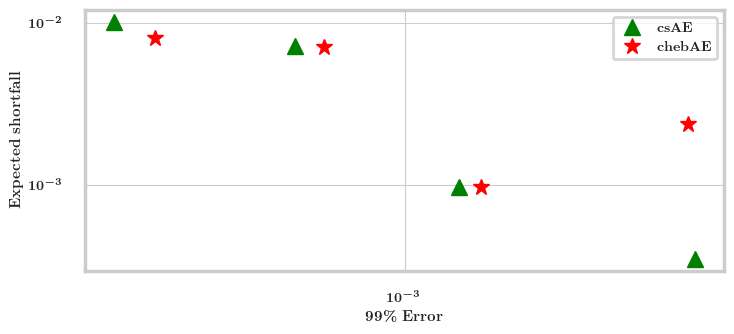

In [11]:
plt.plot(ninetyninepercentile,csae_es_99, "^g", label=r'\textbf{csAE}')
plt.plot(ninetyninepercentile_chebae,chebae_es_99, "*r", label=r'\textbf{chebAE}')
plt.gca().invert_xaxis()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'\textbf{99\% Error}')
plt.ylabel(r'\textbf{Expected shortfall}')
plt.legend()
plt.tight_layout()

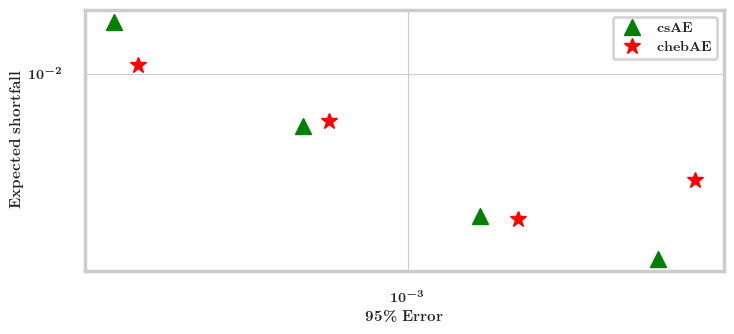

In [12]:
plt.plot(ninetyfivepercentile,csae_es_95, "^g", label=r'\textbf{csAE}')
plt.plot(ninetyfivepercentile_chebae,chebae_es_95, "*r", label=r'\textbf{chebAE}')
plt.gca().invert_xaxis()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'\textbf{95\% Error}')
plt.ylabel(r'\textbf{Expected shortfall}')
plt.legend()
plt.tight_layout()

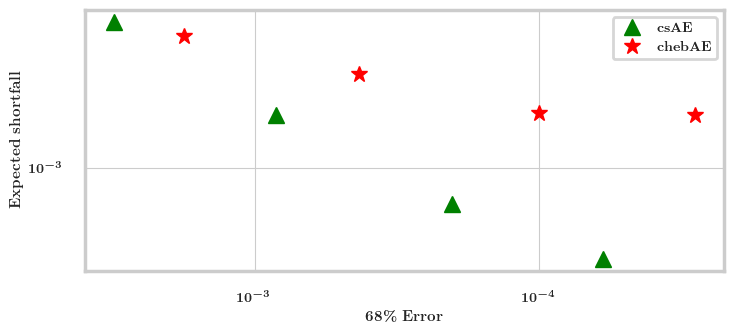

In [13]:
plt.plot(sixtyeightpercentile,csae_es_68, "^g", label=r'\textbf{csAE}')
plt.plot(sixtyeightpercentile_chebae,chebae_es_68, "*r", label=r'\textbf{chebAE}')
plt.gca().invert_xaxis()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'\textbf{68\% Error}')
plt.ylabel(r'\textbf{Expected shortfall}')
plt.legend()
plt.tight_layout()

## Fig. 2

<Figure size 750x350 with 0 Axes>

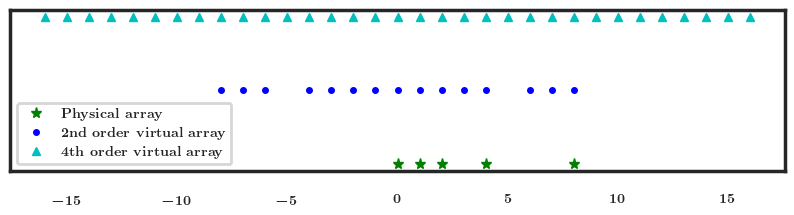

In [14]:
sns.set_style("white")

sns.despine(left=True, bottom=True)
sns.set_context("poster", font_scale = .45, rc={"grid.linewidth": 0.8})
plt.rcParams["text.latex.preamble"] = r'\boldmath'
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"]})
plt.figure(figsize=(10, 2.1))

ula_signal = TwoqULASignal(M=[2]*4)
ula_signal.get_idx()
virtual_locations = ula_signal.virtual_locations

colors = ['r.', 'b.', 'c.', 'g.', 'k.']
plt.plot(ula_signal.depths, [0]*len(ula_signal.depths),  'g*', label=r'\textbf{Physical array}', ms=8)
plt.plot(virtual_locations[0], [(1)*0.2]*len(virtual_locations[0]), 'b.', label=r'\textbf{2nd order virtual array}', ms=8)
plt.plot(virtual_locations[1], [(2)*0.2]*len(virtual_locations[1]), 'c^', label=r'\textbf{4th order virtual array}', ms=6)
plt.gca().axes.yaxis.set_ticklabels([])

plt.legend()
plt.savefig('figs/virtual_locations.pdf')

# Table 2
To generate table 2, we first loop through all our precomputed data for the various noise values to find the number of samples required to achieve a target estimate error rate of 1e-3 at a given confidence level. Because we used an exponential schedule to generate scaling curves, in some cases, the max depth is too high. In that case, we tweak the parameters of the 2q array to try and find a "sweet spot" in between the powers of 2. The 2q array approach allows us to do this by varying the array parameters and not just use powers of 2

In [15]:
# Here we go loop over our precomputed data with the exponential arrays and 
# figure out how many samples are required. We report the samples as well as 
# the error rate required to get a 1e-3 error rate

ninetyninepercentile = {}
ninetyfivepercentile = {}
sixtyeightpercentile = {}
median = {}

epsilon = 1e-3

def find_max_query(error_percentile, queries, max_single_query):
    largest_query = 0
    largest_max_single_query = 0
    largest_error = 0


    # If a given amplitude cannot achieve the target error rate, then we just exit
    if min(error_percentile) > epsilon:
        return np.inf, np.inf, np.inf
        
    # Otherwise loop through and figure out what the maximum number of queries 
    # one needs to achieve the target error rate
    for idx in range(len(error_percentile)):
        error = error_percentile[idx]
        
        if (error < epsilon) and (largest_query <= queries[idx]):
            largest_query = queries[idx]
            largest_max_single_query = max_single_query[idx]

            if error > largest_error:
                largest_error = error
            # break out of the loop because we found the first point where error < epsilon
            break

    return largest_query, largest_max_single_query, largest_error


with open(dir+f'csae_C{C95:0.3f}_mc0500.pkl', 'rb') as handle:
    errors, thetas, errors_exact_signs, thetas_exact_signs, num_queries, max_single_query, arrays, num_lengths, num_mc, avals = pickle.load(handle)

with open(dir+f'csae_C{C99:0.3f}_mc0500.pkl', 'rb') as handle:
    errors99, thetas99, errors_exact_signs99, thetas_exact_signs99, num_queries99, max_single_query99, arrays99, num_lengths99, num_mc99, avals99 = pickle.load(handle)
    
ninetyninepercentile = np.percentile(errors99, 99, axis=1)
ninetyfivepercentile = np.percentile(errors, 95, axis=1)
sixtyeightpercentile = np.percentile(errors, 68, axis=1)
median = np.percentile(errors, 50, axis=1)

# Find the largest number of queries needed to get a target error of 1e-3 at a given confidence interval
largest_query99, largest_max_single_query99, largest_error99 = find_max_query(ninetyninepercentile, num_queries99, max_single_query99)
largest_query95, largest_max_single_query95, largest_error95 = find_max_query(ninetyfivepercentile, num_queries, max_single_query)
largest_query68, largest_max_single_query68, largest_error68 = find_max_query(sixtyeightpercentile, num_queries, max_single_query)
largest_query50, largest_max_single_query50, largest_error50 = find_max_query(median, num_queries, max_single_query)


print(f'   99% Error: {largest_error99:0.3E}')
print(f'   99% Total number of queries required: {largest_query99}')
print(f'   99% Max depth queries required: {largest_max_single_query99}\n')

print(f'   95% Error: {largest_error95:0.3E}')
print(f'   95% Total number of queries required: {largest_query95}')
print(f'   95% Max depth queries required: {largest_max_single_query95}\n')

print(f'   68% Error: {largest_error68:0.3E}')
print(f'   68% Total number of queries required: {largest_query68}')
print(f'   68% Max depth queries required: {largest_max_single_query68}\n')

print(f'   50% Error: {largest_error50:0.3E}')
print(f'   50% Total number of queries required: {largest_query50}')
print(f'   50% Max depth queries required: {largest_max_single_query50}\n')

   99% Error: 6.844E-04
   99% Total number of queries required: 16464
   99% Max depth queries required: 512

   95% Error: 6.051E-04
   95% Total number of queries required: 8232
   95% Max depth queries required: 512

   68% Error: 8.425E-04
   68% Total number of queries required: 2080
   68% Max depth queries required: 128

   50% Error: 5.564E-04
   50% Total number of queries required: 2080
   50% Max depth queries required: 128



In [16]:
# This cell defines a helper function that is used to compute the 
# number of samples required to achieve 1e-3 error at 
# 99%, 95%, and 68% confidence

narrays = {}
csae_percentile = {}
chebae_percentile = {}
C_max_sequential_chebae = {}
C_max_parallel_chebae = {}
C_ave_sequential_chebae = {}
C_ave_parallel_chebae = {}
C_sequential_csae = {}
C_parallel_csae = {}

def run_target_percentile(num_mc, perc, narray, C, repeat=1):
    global narrays
    global csae_percentile
    global chebae_percentile
    global C_max_sequential_chebae
    global C_max_parallel_chebae
    global C_ave_sequential_chebae
    global C_ave_parallel_chebae
    global C_sequential_csae
    global C_parallel_csae

    kp = str(perc)
    narrays[kp] = narray

    all_a_ests = np.zeros((num_mc, repeat), dtype = float)
    all_errors = np.zeros((num_mc, repeat), dtype = float)
    
    a_ests = np.zeros(num_mc, dtype = float)
    errors = np.zeros(num_mc, dtype = float)
    avals  = [np.random.uniform(0.1, 0.9) for _ in range(num_mc)]
    
    espirit = ESPIRIT()
    
    # Create ULA object. Requires array parameters narray and an optional C parameter 
    # that defines how many samples to take.
    ula_signal = TwoqULASignal(M=narrays[kp], C=C)
    # Create ESPIRIT Object
    esprit = ESPIRIT()
    
    
    # This function "learns" the distribution of signs through simulation
    heavy_signs = get_heavy_signs(ula_signal.depths, ula_signal.n_samples, len(narray)**2)
    
    running_error = 0
    for k in (pbar := tqdm(range(num_mc))):

        for ell in range(repeat):
            ############ Simulation Code ##############
            # This portion of code is only used for simulation purposes. If you wish to use this code
            # with exprimental values, this will be replaced and one will set the measurement values
            # directly using the ula_signal.set_measurements(measurements) method.
            
            # Simulate a noisy set of measurements for the given angle theta. Simulator also returns the
            # actual complext signal csignal that is not available from an actual experiment
            theta = np.arcsin(avals[k])
            csignal, measurements = simulate_signal(ula_signal.depths, ula_signal.n_samples, theta)
            ############ End Simulation Code ##############
            
            
            # Set the measurement probabilities using an array of length depths that correspond to the 
            # probability of measuring the |0,x> state in the state psi> = a|0,x> + sqrt{1-a^2}|1,x'>. 
            # This corresponds to |a|^2. Here we use the simulated measurements, but this could be experimental
            # measurements as well.
            ula_signal.set_measurements(measurements)
            # This function is a simple helper function that takes the ula_signal object and the learned 
            # distribution of signs and estimates the amplitude a
            a_est = estimate_amplitude(ula_signal, heavy_signs, adjacency=5)
            # Error is just the absolute difference
            err = np.abs(avals[k] - a_est)

            all_a_ests[k,ell] = a_est
            all_errors[k,ell] = err
    
        # a_ests[k] = a_est            
        # errors[k] = err
        a_ests[k] = np.median(all_a_ests, axis=1)[k]
        errors[k] = np.median(all_errors, axis=1)[k]
        running_error = np.percentile(errors[:k+1], perc)
        pbar.set_description(f"{kp}% Error: {running_error:0.3e}")
        
    # Store percentile
    csae_percentile[kp]=np.percentile(errors, perc)
    
    # Compute the total queries. We also add the 0 depth query estimate which is often neglected.
    num_queries = repeat*(np.sum(np.array(ula_signal.depths) * np.array(ula_signal.n_samples)) + ula_signal.n_samples[0])
    max_single_query = np.max(ula_signal.depths)
    # Compute the constant parameter for csae
    C_sequential_csae[kp]=num_queries*csae_percentile[kp]
    C_parallel_csae[kp]=max_single_query*csae_percentile[kp]
    
    # Compare to chebae
    errors_chebae, queries_chebae, time_complexity_chebae = \
            simulate_chebAE(avals=avals, epsilons=[1e-3], delta=1-perc/100, num_mc=num_mc)
    chebae_percentile[kp]      = np.percentile(errors_chebae, perc)
    C_max_sequential_chebae[kp]=np.max(queries_chebae)*chebae_percentile[kp]
    C_max_parallel_chebae[kp]  =np.max(time_complexity_chebae)*chebae_percentile[kp]
    C_ave_sequential_chebae[kp]=np.mean(queries_chebae)*chebae_percentile[kp]
    C_ave_parallel_chebae[kp]  =np.mean(time_complexity_chebae)*chebae_percentile[kp]
    
    
    print('***csAE Results***')
    print(f'Array: {narrays[kp]}')
    print(f'Depths: {ula_signal.depths}')
    print(f'Samples at each depth: {ula_signal.n_samples}')
    print(f'{kp}% percentile csAE:   {csae_percentile[kp]:e}')
    print(f'Number of queries csAE: {num_queries}')
    print(f'Max Single Query csAE:  {max_single_query}')
    print(f'C param sequential csAE: {C_sequential_csae[kp]:0.3f}')
    print(f'C param parallel csAE:   {C_parallel_csae[kp]:0.3f}')
    
    
    
    print()
    print('***chebAE Results***')
    print(f'{kp}% percentile chebAE: {chebae_percentile[kp]:e}')
    print(f'Max number of queries chebAE: {np.max(queries_chebae)}')
    print(f'Max parallel queries chebAE:  {np.max(time_complexity_chebae)}')
    print(f'Ave number of queries chebAE: {np.mean(queries_chebae)}')
    print(f'Ave parallel queries chebAE:  {np.mean(time_complexity_chebae)}')
    print(f'Max C param sequential chebAE: {C_max_sequential_chebae[kp]:0.3f}')
    print(f'Max C param parallel csAE:     {C_max_parallel_chebae[kp]:0.3f}')
    print(f'Ave C param sequential chebAE: {C_ave_sequential_chebae[kp]:0.3f}')
    print(f'Ave C param parallel csAE:     {C_ave_parallel_chebae[kp]:0.3f}')
    print()

## 99% Confidence
Provides array and sampling parameters to achieve $\epsilon\le 10^{-3}$ error rate at 99% confidence. This cell takes about 2.5 hours to run in a single thread on a laptop.

In [17]:
np.random.seed(7)
num_mc = 500
perc = 99
kp = str(perc)
narray=[2,2,2,2,2,2,2,2,2]

run_target_percentile(num_mc, perc, narray, 8.1) 

99% Error: 9.261e-04: 100%|█████████████████| 500/500 [2:33:50<00:00, 18.46s/it]


***csAE Results***
Array: [2, 2, 2, 2, 2, 2, 2, 2, 2]
Depths: [  0   1   2   4   8  16  32  64 128 256]
Samples at each depth: [162, 73, 65, 57, 49, 41, 33, 25, 17, 9]
99% percentile csAE:   9.260683e-04
Number of queries csAE: 8777
Max Single Query csAE:  256
C param sequential csAE: 8.128
C param parallel csAE:   0.237

***chebAE Results***
99% percentile chebAE: 9.035108e-04
Max number of queries chebAE: 7918.0
Max parallel queries chebAE:  7324.0
Ave number of queries chebAE: 5487.976
Ave parallel queries chebAE:  5052.97
Max C param sequential chebAE: 7.154
Max C param parallel csAE:     6.617
Ave C param sequential chebAE: 4.958
Ave C param parallel csAE:     4.565



## 95% Confidence
Provides array and sampling parameters to achieve $\epsilon\le 10^{-3}$ error rate at 95% confidence. This cell takes about 2 hours to run in a single thread on a laptop.

In [18]:
np.random.seed(7)
num_mc = 500
perc = 95
kp = str(perc)
narray=[2,2,4,2,2,2,2,2]

run_target_percentile(num_mc, perc, narray, C95)

95% Error: 9.846e-04: 100%|█████████████████| 500/500 [1:50:15<00:00, 13.23s/it]


***csAE Results***
Array: [2, 2, 4, 2, 2, 2, 2, 2]
Depths: [  0   1   2   4   8  12  16  32  64 128 256]
Samples at each depth: [88, 40, 36, 32, 28, 24, 20, 16, 12, 8, 4]
95% percentile csAE:   9.846000e-04
Number of queries csAE: 4488
Max Single Query csAE:  256
C param sequential csAE: 4.419
C param parallel csAE:   0.252

***chebAE Results***
95% percentile chebAE: 7.989366e-04
Max number of queries chebAE: 5858.0
Max parallel queries chebAE:  5330.0
Ave number of queries chebAE: 4021.826
Ave parallel queries chebAE:  3692.75
Max C param sequential chebAE: 4.680
Max C param parallel csAE:     4.258
Ave C param sequential chebAE: 3.213
Ave C param parallel csAE:     2.950



## 68% Confidence
Provides array and sampling parameters to achieve $\epsilon\le 10^{-3}$ error rate at 68% confidence.

In [19]:
np.random.seed(7)
num_mc = 500
perc = 68
kp = str(perc)
narray=[2,2,2,2,2,2,2,2]

run_target_percentile(num_mc, perc, narray, 3.0)

68% Error: 9.796e-04: 100%|███████████████████| 500/500 [38:21<00:00,  4.60s/it]


***csAE Results***
Array: [2, 2, 2, 2, 2, 2, 2, 2]
Depths: [  0   1   2   4   8  16  32  64 128]
Samples at each depth: [54, 24, 21, 18, 15, 12, 9, 6, 3]
68% percentile csAE:   9.796122e-04
Number of queries csAE: 1560
Max Single Query csAE:  128
C param sequential csAE: 1.528
C param parallel csAE:   0.125

***chebAE Results***
68% percentile chebAE: 5.335370e-04
Max number of queries chebAE: 3752.0
Max parallel queries chebAE:  3417.0
Ave number of queries chebAE: 2444.168
Ave parallel queries chebAE:  2220.428
Max C param sequential chebAE: 2.002
Max C param parallel csAE:     1.823
Ave C param sequential chebAE: 1.304
Ave C param parallel csAE:     1.185



## 50% Confidence
Provides array and sampling parameters to achieve $\epsilon\le 10^{-3}$ error rate at 50% confidence.

In [20]:
np.random.seed(7)
num_mc = 500
perc = 50
kp = str(perc)
narray=[2,2,2,2,2,2,2,2]

run_target_percentile(num_mc, perc, narray, 2)

50% Error: 8.894e-04: 100%|███████████████████| 500/500 [38:41<00:00,  4.64s/it]


***csAE Results***
Array: [2, 2, 2, 2, 2, 2, 2, 2]
Depths: [  0   1   2   4   8  16  32  64 128]
Samples at each depth: [36, 16, 14, 12, 10, 8, 6, 4, 2]
50% percentile csAE:   8.894265e-04
Number of queries csAE: 1040
Max Single Query csAE:  128
C param sequential csAE: 0.925
C param parallel csAE:   0.114

***chebAE Results***
50% percentile chebAE: 4.022705e-04
Max number of queries chebAE: 3405.0
Max parallel queries chebAE:  3109.0
Ave number of queries chebAE: 2079.416
Ave parallel queries chebAE:  1898.84
Max C param sequential chebAE: 1.370
Max C param parallel csAE:     1.251
Ave C param sequential chebAE: 0.836
Ave C param parallel csAE:     0.764



## Fig. 5
## Parallel query complexity versus number of quantum computers

88


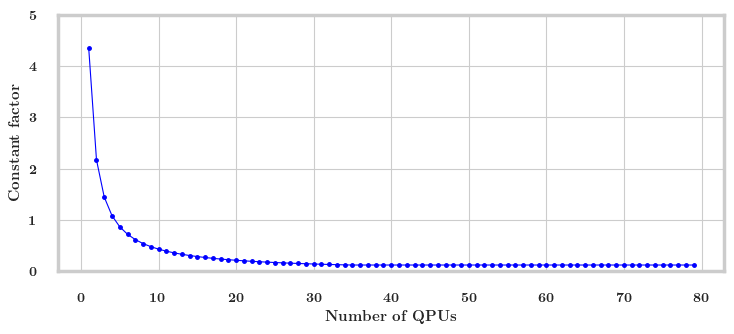

In [21]:
# to divide the queries evenly among the n quantum computers, we view depths as the weight of n objects and n_samples the number of each such item
# we want to divide these objects as evenly as possible according to the weight
# this is related to the partition problem, which is an NP-complete problem
# we will use the greedy approach mentioned here: https://en.wikipedia.org/wiki/Partition_problem#Approximation_algorithm_approaches
kp = '95'

ula_signal = TwoqULASignal(M=narrays[kp], C=C95)

ula_signal.get_idx()

n_samples = np.array(ula_signal.n_samples)
n0 = n_samples[0]
n_samples = 2*n_samples
n_samples[0] = n0

print(n0)

depths = ula_signal.depths
depths[0] = 1

def part_sums(n_samples, depths, num_parts):
    S = []
    for i, d in enumerate(depths):
        S = S + [d]*n_samples[i]

    partitions = []
    for _ in range(num_parts):
        partitions.append([])

    while len(S)!=0:
        S.sort(reverse=True)
        part_sums = []
        for part in partitions:
            part_sums.append(np.sum(part))
        idx = list(np.argsort(part_sums))
        partitions = [partitions[i] for i in idx]

        x = S.pop(0)
        partitions[0].append(x)
    part_sums = []
    for part in partitions:
        part_sums.append(np.sum(part))      

    return part_sums

quantum_computers = list(range(1, 16))
quantum_computers = list(range(1, 80))
fractions = np.zeros(len(quantum_computers))


for i, num_parts in enumerate(quantum_computers):
    p_sums = part_sums(n_samples=n_samples, depths=depths, num_parts=num_parts)
    fractions[i] = max(p_sums)/(np.sum(n_samples*depths))

# now plot constant factor against number of quantum computers
ms=5
lw=0.8

#C= 6960*4.6*10**(-4) # this is the constant factor for the query complexity for amplitude 0.5 for q=5
# C = C_csae_ave95 # This is the constant factor determined from the fit

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["font.size"] = 12
plt.rcParams["text.latex.preamble"] = r'\boldmath'
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"]})

plt.plot(quantum_computers, C_csae_ave95*fractions, '.-b', ms=ms, linewidth=lw)

plt.ylim([0.0, 5.0])
plt.xlabel(r'\textbf{Number of QPUs}')
plt.ylabel(r'\textbf{Constant factor}')
plt.tight_layout()
plt.savefig('figs/constant_factors_qpus.pdf')

79
[  1   1   2   4   8  12  16  32  64 128 256]
[88 80 72 64 56 48 40 32 24 16  8]
528
8976
9.999943e-04
2.9502732431718965
3.2131841138698953


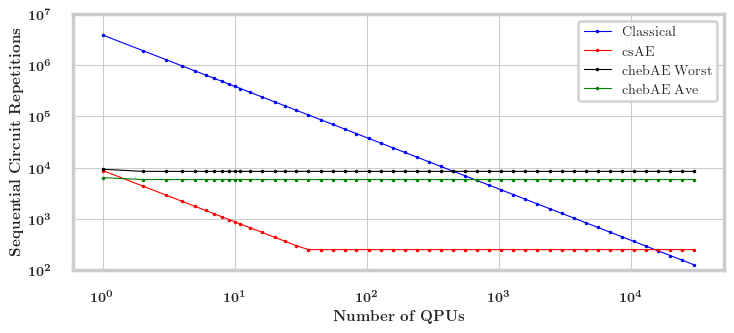

In [22]:
# Compute confidence interval using Clopper-Pearson for a=0.5
# Goal, compute how 2, 3, 4,... QPU's would speedup runtime relative to straight sampling
kp = '95'

print(len(fractions))
print(depths)
print(n_samples)
print(np.sum(n_samples))
print(np.sum(depths*n_samples) + n_samples[0])

epsilon = 1e-3
a=0.5
n=3843500 # Chosen to get 1e-3 error rate for classical sampling
alpha=0.05
Nq = 30000
p_u, p_o = st.beta.ppf([alpha/2, 1-alpha/2], [n*a, n*a+1], [n-n*a+1, n-n*a])
print(f'{p_o-p_u:e}')
max_length=depths[-1]
total_quantum_computers = np.array(list(range(1, Nq)))
runtime_classical = n/np.array(total_quantum_computers)


# ave_runtime_chebae = [2*C_cheb_time95[0]/epsilon]*(Nq-1)
# max_runtime_chebae = [2*C_cheb_time_max95[0]/epsilon]*(Nq-1)
ave_runtime_chebae = np.array([2*C_ave_parallel_chebae[kp]/epsilon]*(Nq-1))
max_runtime_chebae = np.array([2*C_max_parallel_chebae[kp]/epsilon]*(Nq-1))
ave_runtime_chebae[0] = np.array(2*C_ave_sequential_chebae[kp]/epsilon)
max_runtime_chebae[0] = np.array(2*C_max_sequential_chebae[kp]/epsilon)
print(C_ave_parallel_chebae[kp])
print(C_ave_sequential_chebae[kp])


end_fractions = np.ones(len(total_quantum_computers)-len(fractions))*fractions[-1]
extended_fractions = np.append(fractions, end_fractions)
# runtime_quantum = (2*C_csae_ave95*extended_fractions/epsilon)
runtime_quantum = (2*C_sequential_csae[kp]*extended_fractions/epsilon)




sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["font.size"] = 12
plt.rcParams["text.latex.preamble"] = r'\boldmath'
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"]})

base=10
linpoints = np.linspace(0,9,num=10,dtype=int)
logpoints = np.logspace(0,np.log(Nq)/np.log(base), dtype=int)
pltpoints = np.unique(np.concatenate([linpoints,logpoints]))
pltpoints[-1] = Nq-2

plt.plot(total_quantum_computers[pltpoints], runtime_classical[pltpoints], '.-b', ms=ms-2, linewidth=lw, label='Classical')
plt.plot(total_quantum_computers[pltpoints], runtime_quantum[pltpoints], '.-r', ms=ms-2, linewidth=lw, label='csAE')
plt.plot(total_quantum_computers[pltpoints], max_runtime_chebae[pltpoints], '.-k', ms=ms-2, linewidth=lw, label='chebAE Worst')
plt.plot(total_quantum_computers[pltpoints], ave_runtime_chebae[pltpoints], '.-g', ms=ms-2, linewidth=lw, label='chebAE Ave')

# plt.ylim([0.0, 5.0])
plt.yscale('log')
plt.xscale('log')
plt.ylim([100, 10**7])
#plt.xlim([0.9, 10**4.8])
plt.xlabel(r'\textbf{Number of QPUs}')
plt.ylabel(r'\textbf{Sequential Circuit Repetitions}')
plt.legend()
plt.tight_layout()
plt.savefig('figs/speedup.pdf')